# PPFT example notebook
This notebook contains a toy example of training with the PPFT (property prediction fine-tuning) loss. In this example, the pretrained BioEmu model is finetuned to modify the proportion of folded states that it samples for a single protein.

Finetuning in this narrow way may well have detrimental effects on model performance. In [our own work](https://doi.org/10.1101/2024.12.05.626885) when we finetuned with PPFT, we interspersed PPFT weight updates with standard denoising score-matching updates using structures of a large variety of proteins.

In [5]:
from pathlib import Path

OUTPUT_DIR = Path("~/prj-mlcv/lib/bioemu/ppft_example_output").expanduser()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
repo_dir = Path("~/prj-mlcv/lib/bioemu").expanduser()
rollout_config_path = repo_dir / "notebook" / "rollout.yaml"
# Reference structure downloaded from https://zenodo.org/records/7992926
reference_pdb = repo_dir / "notebook" / "HHH_rd1_0335.pdb"
assert reference_pdb.exists(), f"Reference structure not found at {reference_pdb}"

In [6]:
# Compute reference contacts using the reference structure.
from bioemu.training.foldedness import TargetInfo, compute_contacts
import mdtraj


reference_traj = mdtraj.load(reference_pdb)
reference_traj = reference_traj.atom_slice(reference_traj.topology.select("name CA"))
reference_info = compute_contacts(traj=reference_traj)

In [7]:
from bioemu.sample import main as sample_main
from bioemu.training.foldedness import compute_fnc_for_list, foldedness_from_fnc
import torch
from bioemu.chemgraph import ChemGraph
from matplotlib import pyplot as plt

STEEPNESS = 10.0
P_FOLD_THR = 0.5


def sample_and_compute_metrics(
    output_dir: Path,
    ckpt_path: Path | None = None,
    model_config_path: Path | None = None,
    denoiser_config_path: Path | None = None,
    num_samples: int = 300,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Generate samples and compute their FNC and foldedness metrics.

    Returns:
        tuple: (fnc, foldedness) tensors
    """
    # Generate samples.
    sample_main(
        sequence=reference_info.sequence,
        num_samples=num_samples,
        output_dir=output_dir,
        filter_samples=False,
        ckpt_path=ckpt_path,
        model_config_path=model_config_path,
        denoiser_config_path=denoiser_config_path,
    )

    # Compute fraction of native contacts (FNC) and foldedness of the samples.
    traj = mdtraj.load(output_dir / "samples.xtc", top=output_dir / "topology.pdb")
    traj = traj.atom_slice(traj.topology.select("name CA"))
    chemgraph_list = [
        ChemGraph(pos=torch.tensor(traj.xyz[i]), sequence=reference_info.sequence)
        for i in range(len(traj))
    ]
    fnc = compute_fnc_for_list(batch=chemgraph_list, reference_info=reference_info)
    foldedness = foldedness_from_fnc(fnc=fnc, p_fold_thr=P_FOLD_THR, steepness=STEEPNESS)

    return fnc, foldedness


def sample_and_plot(
    output_dir: Path,
    ckpt_path: Path | None = None,
    model_config_path: Path | None = None,
    denoiser_config_path: Path | None = None,
    num_samples: int = 300,
) -> None:
    """Generate samples, compute metrics, and plot their distributions."""

    # Get metrics
    fnc, foldedness = sample_and_compute_metrics(
        output_dir=output_dir,
        ckpt_path=ckpt_path,
        model_config_path=model_config_path,
        denoiser_config_path=denoiser_config_path,
        num_samples=num_samples,
    )

    # Plot the results.
    plt.subplot(1, 2, 1)
    plt.hist(fnc.numpy(), bins=50, density=True)
    plt.xlim(0, 1)
    plt.xlabel("FNC")
    plt.ylabel("Density")
    plt.title("Fraction of native contacts")
    plt.text(
        0.5,
        0.9,
        f"Mean FNC: {fnc.mean().item():.3f}",
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

    plt.subplot(1, 2, 2)
    plt.hist(foldedness.numpy(), bins=50, density=True)
    plt.xlim(0, 1)
    plt.xlabel("Foldedness")
    plt.ylabel("Density")
    plt.title("Foldedness")
    plt.text(
        0.5,
        0.9,
        f"Mean foldedness: {foldedness.mean().item():.2f}",
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

    plt.savefig(output_dir / "histograms.png")

Sampling batches...: 100%|██████████| 6/6 [00:35<00:00,  5.86s/it]
File "/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/hydra/_internal/utils.py", line 644, in _locate
    614  def _locate(path: str) -> Any:
 (...)
    640          ) from exc_import
    641      for m in range(1, len(parts)):
    642          part = parts[m]
    643          try:
--> 644              obj = getattr(obj, part)
    645          except AttributeError as exc_attr:
    ..................................................
     path = 'bioemu.training.loss._rollout'
     m = 2
     parts = ['bioemu', 'training', 'loss', '_rollout', ]
     part = 'loss'
     obj = <module 'bioemu.training' (<_frozen_importlib_external._Name
            spaceLoader object at 0x7f75d40c4fa0>)>
    ..................................................

AttributeError: module 'bioemu.training' has no attribute 'loss'

While handling the above exception, another exception occurred:

File "/home/shpark/.conda/envs/bioemu4/l

InstantiationException: Error locating target 'bioemu.training.loss._rollout', set env var HYDRA_FULL_ERROR=1 to see chained exception.

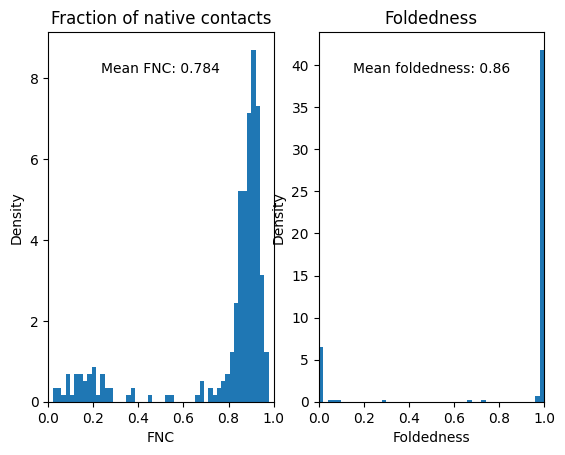

<Figure size 640x480 with 0 Axes>

In [8]:
# Sample and plot distributions of FNC and foldedness using default checkpoint and denoiser config.
pretrained_samples_dir = OUTPUT_DIR / "pretrained_samples"
sample_and_plot(output_dir=pretrained_samples_dir, ckpt_path=None)

# For comparison, also show FNC and foldedness when sampling with the fast 'rollout' denoiser.
plt.figure()
sample_and_plot(
    output_dir=OUTPUT_DIR / "pretrained_samples_fast",
    ckpt_path=None,
    denoiser_config_path=rollout_config_path,
)

In [ ]:
import shutil
import yaml

import torch.nn as nn

from bioemu.model_utils import load_model, load_sdes, maybe_download_checkpoint
from bioemu.training.loss import calc_ppft_loss
from bioemu.sample import get_context_chemgraph

rollout_config = yaml.safe_load(rollout_config_path.read_text())


def freeze_parameters_check_missing(model: nn.Module, exclude_patterns: list[str]) -> None:
    """
    Freeze parameters of a model based on the provided patterns.

    Args:
        model: The model whose parameters are to be frozen.
        exclude_patterns: The list of patterns to exclude from freezing.

    Raises:
        ValueError: If any pattern in exclude_patterns is not found in the model's parameters.
    """

    # Patterns of parameters to exclude.
    found_patterns = set()
    for prm_label, prm in model.named_parameters():
        # Set requires_grad based on the presence of the pattern
        requires_grad = any([p in prm_label for p in exclude_patterns])
        prm.requires_grad = requires_grad
        # Update found_patterns set if the pattern is found
        if requires_grad:
            found_patterns.update({p for p in exclude_patterns if p in prm_label})

    # Calculate the missing patterns by subtracting found_patterns from exclude_patterns
    missing_patterns = set(exclude_patterns) - found_patterns
    # Raise an error if any pattern in exclude_patterns is not found in the model's parameters
    if missing_patterns:
        raise ValueError(
            f"The following patterns to fine-tune were not found in the model: {', '.join(missing_patterns)}"
        )


def finetune_with_target(
    p_fold_target: float, n_steps_train: int, seed: int = 42
) -> tuple[Path, Path]:
    """Finetune the pretrained BioEmu model to sample structures with mean foldedness p_fold_target."""
    output_dir = OUTPUT_DIR / f"target_{p_fold_target:.2f}_seed_{seed}"
    output_dir.mkdir(parents=True, exist_ok=True)
    torch.manual_seed(seed)
    target_info = TargetInfo(
        p_fold_thr=P_FOLD_THR, steepness=STEEPNESS, p_fold_target=p_fold_target
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ckpt_path, model_config_path = maybe_download_checkpoint(model_name="bioemu-v1.0")
    shutil.copy(model_config_path, output_dir / "config.yaml")
    model_config_path = output_dir / "config.yaml"
    sdes = load_sdes(model_config_path=model_config_path)
    score_model = load_model(ckpt_path=ckpt_path, model_config_path=model_config_path).to(device)
    freeze_parameters_check_missing(
        score_model, exclude_patterns=["encoder.layers.0", "encoder.layers.7"]
    )
    score_model.train()
    system_id = reference_pdb.stem
    chemgraph = (
        get_context_chemgraph(sequence=reference_info.sequence)
        .replace(system_id=system_id)
        .to(device)
    )
    assert chemgraph.sequence == reference_info.sequence, (
        "ChemGraph sequence does not match reference sequence"
    )
    optimizer = torch.optim.Adam(
        score_model.parameters(),
        lr=1e-5,
        eps=1e-6,
    )

    # Track training metrics
    train_losses = []
    val_iterations = []
    val_mean_foldedness = []

    # Validation function
    def validate(iteration: int, num_samples: int = 100) -> float:
        """Generate samples and compute mean foldedness for validation."""
        print(f"Running validation at iteration {iteration}...")
        val_dir = output_dir / f"val_iter_{iteration}"
        val_dir.mkdir(exist_ok=True)

        # Save current model state temporarily
        temp_ckpt = val_dir / "temp_model.ckpt"
        torch.save(score_model.state_dict(), temp_ckpt)

        # Generate validation samples and compute metrics
        fnc, foldedness = sample_and_compute_metrics(
            output_dir=val_dir,
            ckpt_path=temp_ckpt,
            model_config_path=model_config_path,
            denoiser_config_path=rollout_config_path,
            num_samples=num_samples,
        )

        mean_fold = foldedness.mean().item()
        print(f"Validation at iteration {iteration}: mean foldedness = {mean_fold:.3f}")

        # Clean up temporary checkpoint
        temp_ckpt.unlink()

        return mean_fold

    for i in range(n_steps_train):
        print(f"Iteration {i + 1}/{n_steps_train}")
        optimizer.zero_grad()
        loss = calc_ppft_loss(
            score_model=score_model,
            sdes=sdes,
            batch=[chemgraph] * 10,
            n_replications=4,
            mid_t=rollout_config["mid_t"],
            target_info_lookup={system_id: target_info},
            N_rollout=rollout_config["N_rollout"],
            record_grad_steps=rollout_config["record_grad_steps"],
            reference_info_lookup={system_id: reference_info},
        )
        loss.backward()
        assert not torch.isnan(loss).any(), "Loss contains NaN values"
        optimizer.step()

        # Record training loss
        train_losses.append(loss.item())
        print(f"  Loss: {loss.item():.4f}")

        # Run validation periodically.
        if i % 20 == 0:
            with torch.random.fork_rng():
                # fork_rng because generate_batch called during 'validate' sets the random seed to a fixed value.
                mean_fold = validate(i, num_samples=100)
                val_iterations.append(i)
                val_mean_foldedness.append(mean_fold)

    checkpoint_path = output_dir / f"step_{i + 1}.ckpt"
    torch.save(score_model.state_dict(), checkpoint_path)
    print(f"Model saved to {checkpoint_path}, config at {model_config_path}")

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss curve
    ax1.plot(range(1, len(train_losses) + 1), train_losses)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training Loss")
    ax1.grid(True)

    # Plot validation curve
    ax2.plot(val_iterations, val_mean_foldedness, "o-")
    ax2.axhline(y=p_fold_target, color="r", linestyle="--", label=f"Target: {p_fold_target}")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Mean Foldedness")
    ax2.set_title("Validation: Mean Foldedness")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(output_dir / "training_curves.png")
    plt.show()

    return checkpoint_path, model_config_path


finetuned_checkpoint_path, model_config_path = finetune_with_target(
    p_fold_target=0.5, n_steps_train=200
)

In [ ]:
plt.figure()
sample_and_plot(
    output_dir=finetuned_checkpoint_path.with_suffix(".samples"),
    ckpt_path=finetuned_checkpoint_path,
    model_config_path=model_config_path,
)
plt.figure()
sample_and_plot(
    output_dir=finetuned_checkpoint_path.with_suffix(".rollout_samples"),
    ckpt_path=finetuned_checkpoint_path,
    model_config_path=model_config_path,
    denoiser_config_path=rollout_config_path,
)